# Energy conserving network in tf.keras

This is using https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/005_Predicting_convective_and_radiative_heating_profiles.ipynb



In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from cbrain.imports import *

## Preprocess 

In [2]:
!python ../../preprocessing.py -c ../../pp_config/002_32col_tom.yml

2019-03-29 16:01:45.366202: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2019-03-29 16:01:45.494983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 6.40GiB
2019-03-29 16:01:45.495015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-03-29 16:01:45.940114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-03-29 16:01:45.940148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-03-29 16:01:45.940155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-03-29 16:01:45.940469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorF

## Output normalization using Pressure levels

Using the dict normalizer

In [2]:
out_vars = ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [3]:
from cbrain.cam_constants import *

In [4]:
scale_dict = {
    'PHQ': L_V/G, 
    'PHCLDLIQ': L_V/G, 
    'PHCLDICE': L_V/G, 
    'TPHYSTND': C_P/G, 
    'QRL': C_P/G, 
    'QRS': C_P/G, 
    'DTVKE': C_P/G, 
    'FSNT': 1, 
    'FSNS': 1, 
    'FLNT': 1, 
    'FLNS': 1, 
    'PRECT': RHO_L*L_V, 
    'PRECTEND': 1e-3*RHO_L*L_V, 
    'PRECST': RHO_L*L_V, 
    'PRECSTEN': 1e-3*RHO_L*L_V
}

In [7]:
with open(os.path.join(os.path.dirname('../../cbrain/'), 'hyai_hybi.pkl'), 'rb') as f:
    hyai, hybi = pickle.load(f)

In [8]:
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  

In [10]:
dP.shape

(30,)

In [11]:
for v in ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS']:
    scale_dict[v] *= dP
scale_dict['DTVKE'] *= (dP/DT)

In [33]:
from cbrain.data_generator import DataGenerator
from cbrain.normalization import DictNormalizer

In [34]:
in_vars = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [40]:
train_gen = DataGenerator(
    data_fn = '/local/S.Rasp/preprocessed_data/002_train.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/local/S.Rasp/preprocessed_data/002_norm.nc',
    input_transform = 'max_rs',
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [41]:
X, Y = train_gen[0]

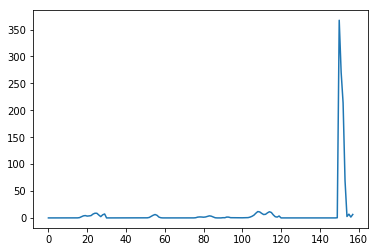

In [47]:
plt.plot(np.mean(np.abs(Y), 0))

## Build the model